In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

np.random.seed(42)
plt.style.use('ggplot')

In [2]:
## PATHS
# Inputs
in_vuelos = 'dataset_SCL.csv'
in_feriados = 'feriados-chile-2017.csv'
in_clima = 'santiago_clima_2017.csv'

# DTypes vuelos para lectura eficiente de DF
dtypes_vuelos = {
    'Vlo-I':str,
    'Vlo-O': str,
    'DIA': int,
    'MES': int,
    'AÑO': int,
}

In [3]:
vuelos = pd.read_csv(in_vuelos, 
                     parse_dates= ['Fecha-I', 'Fecha-O'],
                    dtype= dtypes_vuelos)

In [4]:
display(vuelos.head())
display(vuelos.dtypes)
vuelos.shape

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

(68206, 18)

## 1. Exploratory Data Analysis

Solo un valor nulo para `Fecha-O` que procedo a dropear.

In [5]:
vuelos.isnull().mean()

Fecha-I      0.000000
Vlo-I        0.000000
Ori-I        0.000000
Des-I        0.000000
Emp-I        0.000000
Fecha-O      0.000000
Vlo-O        0.000015
Ori-O        0.000000
Des-O        0.000000
Emp-O        0.000000
DIA          0.000000
MES          0.000000
AÑO          0.000000
DIANOM       0.000000
TIPOVUELO    0.000000
OPERA        0.000000
SIGLAORI     0.000000
SIGLADES     0.000000
dtype: float64

In [6]:
vuelos = vuelos.dropna(subset= ['Vlo-O']).copy()

No tiene registros duplicados.

In [7]:
vuelos.drop_duplicates().shape == vuelos.shape

True

### Fechas

Los vuelos corresponden al año 2017 con una frecuencia estable, salvo por la primera semana del año. Los días sábados la cantidad de vuelos cae considerablemente con respecto al promedio.

En términos de horarios, las frecuencias de vuelos más altas se encuentran en la franja de 6 a 9, mientras que las más bajas se encuentran por la madrugada de 23 a 4.

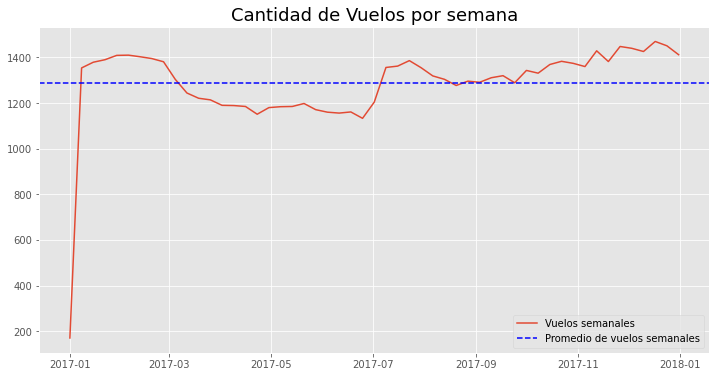

In [8]:
plt.figure(figsize= (12, 6))
plt.plot(vuelos.set_index('Fecha-I').resample('W')['DIA'].count(),
        label= 'Vuelos semanales')
plt.axhline(vuelos.set_index('Fecha-I').resample('W')['DIA'].count().mean(),
           c= 'b',
           ls= '--',
           label= 'Promedio de vuelos semanales')

plt.title('Cantidad de Vuelos por semana', fontsize= 18)
plt.legend()
plt.show()

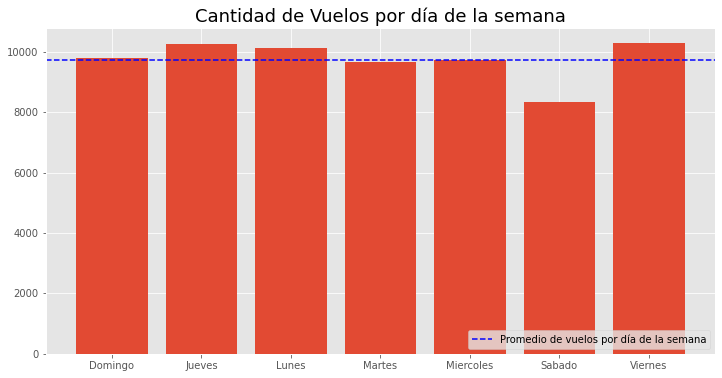

In [9]:
plt.figure(figsize= (12, 6))
plt.bar(vuelos.groupby('DIANOM')['DIA'].count().index, height= vuelos.groupby('DIANOM')['DIA'].count().values)
plt.axhline(vuelos['DIANOM'].value_counts().mean(),
           c= 'b',
           ls= '--',
           label= 'Promedio de vuelos por día de la semana')

plt.title('Cantidad de Vuelos por día de la semana', fontsize= 18)
plt.legend(loc='lower right')
plt.show()

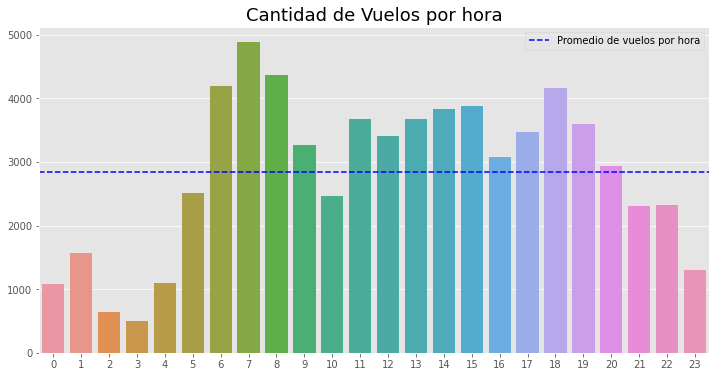

In [10]:
plt.figure(figsize= (12, 6))
horarios_count = vuelos['Fecha-I'].dt.hour.value_counts().sort_index()
sns.barplot(x= horarios_count.index, y= horarios_count.values)
plt.axhline(horarios_count.mean(),
           c= 'b',
           ls= '--',
           label= 'Promedio de vuelos por hora')
plt.title('Cantidad de Vuelos por hora', fontsize= 18)
plt.legend()
plt.show();

### Destinos

La gran mayoría de los destintos tiene menos de 500 viajes en el año, los destinos más populares teniendo entre el 8% y el 4% del total de viajes.

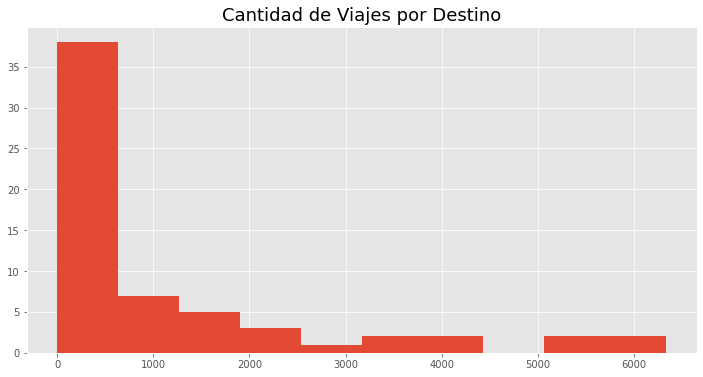

In [11]:
plt.figure(figsize= (12, 6))
vuelos['SIGLADES'].value_counts().hist()
plt.title('Cantidad de Viajes por Destino', fontsize= 18);

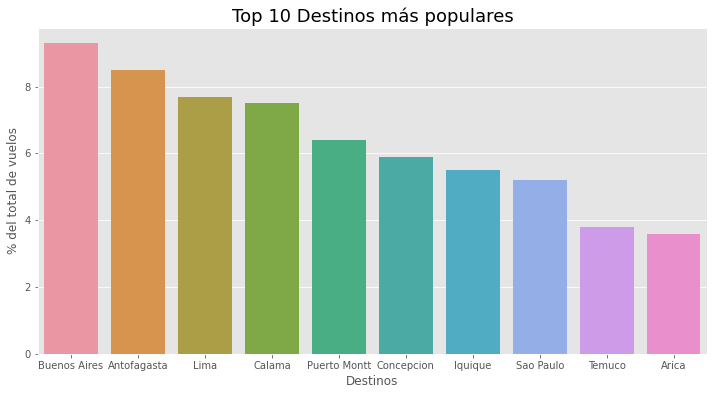

In [12]:
destino_count = np.round(vuelos['SIGLADES'].value_counts(normalize= True).head(10) * 100, 1)
plt.figure(figsize= (12, 6))
sns.barplot(x= destino_count.index, y= destino_count.values)
plt.ylabel('% del total de vuelos')
plt.xlabel('Destinos')
plt.title('Top 10 Destinos más populares', fontsize= 18);

#### Se podrían hacer analisis más exhaustivos sobre las empresas que operan el servicio y los tipos de vuelos que desarrollan.

## 2. Columnas Adicionales

Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv

- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
- dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
- atraso_15 : 1 si dif_min > 15, 0 si no.
- periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I .


### temporada_alta

In [13]:
vuelos['temporada_alta'] = (vuelos['Fecha-I'].between('2017-12-15', '2017-12-31') | \
vuelos['Fecha-I'].between('2017-01-01', '2017-03-03') | \
vuelos['Fecha-I'].between('2017-07-15', '2017-07-31') | \
vuelos['Fecha-I'].between('2017-09-11', '2017-09-30')).astype('int8')

### dif_min

In [14]:
vuelos['dif_min'] = (vuelos['Fecha-O'] - vuelos['Fecha-I']).dt.total_seconds() / 60

### atraso_15

In [15]:
vuelos['atraso_15'] = (vuelos['dif_min'] > 15).astype('int8')

### periodo_dia

In [16]:
vuelos['periodo_dia'] = ''

vuelos.loc[vuelos['Fecha-I'].dt.hour.between(5, 11), 'periodo_dia'] = 'mañana'
vuelos.loc[vuelos['Fecha-I'].dt.hour.between(12, 18), 'periodo_dia'] = 'tarde'
vuelos.loc[(vuelos['Fecha-I'].dt.hour.between(19, 23) | vuelos['Fecha-I'].dt.hour.between(0, 4)), 'periodo_dia'] = 'noche'

## 3. Analisis de Retrasos

¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?

¿Qué variables esperarías que más influyeran en predecir atrasos?

#### Tasa de atraso: asumo que se considera atraso si la diferencia en entre el real y el esperado supera los 15 minutos


En términos de destino, hay destinos con muy pocos vuelos que distorsionan el analisis. Por lo cual se va a tomar como threshold de valor mínimo la cantidad de vuelos correspondientes al primer cuartil dentro de la cantidad por destinos.

In [17]:
pd.crosstab(vuelos.SIGLADES, vuelos.atraso_15, normalize= 'index').sort_values(1)

atraso_15,0,1
SIGLADES,,
Washington,1.000000,0.000000
"Pisco, Peru",1.000000,0.000000
"Curitiba, Bra.",1.000000,0.000000
Cataratas Iguacu,1.000000,0.000000
Houston,0.949102,0.050898
...,...,...
Sydney,0.417526,0.582474
Ushuia,0.333333,0.666667
Cochabamba,0.000000,1.000000


Parece que para los destinos en Europa, Norteamerica y destinos locales no se registran demasiados retrasos, mientras que para Oceania y destinos internacionales en Sudamérica si.

In [18]:
destinos_q1 = vuelos.SIGLADES.value_counts().quantile(0.25)

destinos_relevantes = vuelos.SIGLADES.value_counts()[vuelos.SIGLADES.value_counts() > destinos_q1].index

vuelos_filtrados_destinos = vuelos[vuelos.SIGLADES.isin(destinos_relevantes)]

pd.crosstab(vuelos_filtrados_destinos.SIGLADES, vuelos_filtrados_destinos.atraso_15, normalize= 'index').sort_values(1)

atraso_15,0,1
SIGLADES,,
Houston,0.949102,0.050898
Atlanta,0.941341,0.058659
Ciudad de Panama,0.937297,0.062703
Dallas,0.929972,0.070028
Castro (Chiloe),0.923404,0.076596
Paris,0.913649,0.086351
Puerto Natales,0.911392,0.088608
Ciudad de Mexico,0.905714,0.094286
Roma,0.888031,0.111969


Si bien el hecho de estar en temporada alta podría ser a priori un factor que incida en el retraso de los vuelos, no se registra una evidencia contundente. 

Puede que este efecto ya esté contemplado por las aerolineas y el aeropuerto de Santiago, y estén preparados para estos momentos (mayor frecuencia de vuelos, staffing de empleados en aeropuerto, etc.).

Curiosamente, en el desagregado por mes si se pueden observar patrones para para el retraso de los vuelos. Los meses de Julio y Diciembre muestran ciertos picos en los que podría estar interifiendo fechas de feriados nacionales (Navidad, Año Nuevo). Caso contrario, para el mes de Marzo en el que bajan mucho los retrasos, puede influir el inicio del periodo lectivo en colegios y universidades.

De todos modos, solo estamos observando el año 2017 que puede o no ser representativo. Idealmente sería bueno tener más años para poder observar si la estacionalidad tiene efecto sobre la variable objetivo.

In [19]:
display(pd.crosstab(vuelos.temporada_alta, vuelos.atraso_15, normalize= 'index'))
pd.crosstab(vuelos.MES, vuelos.atraso_15, normalize= 'index')

atraso_15,0,1
temporada_alta,,
0,0.820700,0.179300
1,0.803232,0.196768


atraso_15,0,1
MES,,
1,0.839856,0.160144
2,0.848409,0.151591
3,0.884896,0.115104
4,0.883466,0.116534
5,0.842176,0.157824
6,0.828950,0.171050
7,0.706609,0.293391
8,0.826602,0.173398
9,0.827629,0.172371


Parece que en cuanto a los días de las semana va aparejado con la frecuencia de vuelos, siendo Viernes el que más vuelos registra y por lo tanto más % retraso, caso contrario para el Sábado.

In [20]:
pd.crosstab(vuelos.DIANOM, vuelos.atraso_15, normalize= 'index')

atraso_15,0,1
DIANOM,,
Domingo,0.838914,0.161086
Jueves,0.800488,0.199512
Lunes,0.797848,0.202152
Martes,0.830884,0.169116
Miercoles,0.829150,0.170850
Sabado,0.836806,0.163194
Viernes,0.777983,0.222017


Ciertamente, hay un efecto en si el tipo de vuelo es nacional que internacional, probablemente a partir de la menor/mayor burocracia para uno y para otro.

In [21]:
pd.crosstab(vuelos.TIPOVUELO, vuelos.atraso_15, normalize= 'index')

atraso_15,0,1
TIPOVUELO,,
I,0.774385,0.225615
N,0.849429,0.150571


Algunos otros factores que pueden incidir dentro de un retraso en el vuelo, pueden ser los imprevistos de acuerdo a lo estipulado en el plan.

Analizamos cambios de destino, opereador y vuelo en el efecto sobre un posible atraso.

In [22]:
vuelos['cambio_destino'] = (vuelos['Des-I'] != vuelos['Des-O']).astype('int8')

vuelos['cambio_operador'] = (vuelos['Emp-I'] != vuelos['Emp-O'] ).astype('int8')

vuelos['cambio_vuelo'] = (vuelos['Vlo-I'] != vuelos['Vlo-O'] ).astype('int8')

In [23]:
print('\nCambio de Destino\n')
display(pd.crosstab(vuelos.cambio_destino, vuelos.atraso_15, normalize= 'index'))

print('\nCambio de Operador\n')
display(pd.crosstab(vuelos.cambio_operador, vuelos.atraso_15, normalize= 'index'))

print('\nCambio de Vuelo\n')
display(pd.crosstab(vuelos.cambio_vuelo, vuelos.atraso_15, normalize= 'index'))


Cambio de Destino



atraso_15,0,1
cambio_destino,,
0,0.815099,0.184901
1,0.714286,0.285714



Cambio de Operador



atraso_15,0,1
cambio_operador,,
0,0.813210,0.186790
1,0.819959,0.180041



Cambio de Vuelo



atraso_15,0,1
cambio_vuelo,,
0,0.820073,0.179927
1,0.744356,0.255644


Esta última información, si bien útil de manera analítica, va a quedar afuera del modelo predictivo porque implicaría utilizar información de eventos futuros.

In [24]:
vuelos = vuelos.drop(['cambio_vuelo', 'cambio_operador', 'cambio_destino'], axis= 1)

## 4. Entrenamiento

Entrena uno o varios modelos (usando el/los algoritmo(s) que preﬁeras) para estimar la probabilidad de atraso de un vuelo.
Siéntete libre de generar variables adicionales y/o complementar con variables externas

### 4.1 Feature Engineering

Armo algunas variables por **operador** y **destino** para enriquecer el modelo.

#### Variables por Operador

In [25]:
# Estadisticos de Cantidad de Vuelos por Operador Diarios
features_operador = vuelos.groupby(['OPERA', vuelos['Fecha-I'].dt.date])['DIA']\
                          .count().unstack()\
                          .fillna(0)\
                          .agg(['min', 'mean', 'max', 'median', 'std'], axis= 1)
# Renaming de columnas                          
features_operador.columns = [f'cant_vuelos_operador_diarias_{col}' for col in features_operador.columns]

In [26]:
# Join con DF
vuelos_enr = vuelos.merge(features_operador,
                          left_on= 'OPERA',
                         right_index= True,
                         how= 'left')

In [27]:
# Cantidad de Destinos distintos a los que viaja cada Operador
unique_operador = vuelos.groupby('OPERA')['SIGLADES'].nunique()

unique_operador.name = 'destinos_unicos_por_operador'

In [28]:
# Join con DF
vuelos_enr = vuelos_enr.merge(unique_operador,
                          left_on= 'OPERA',
                         right_index= True,
                         how= 'left')

#### Variables por Destino

In [29]:
# Estadisticos de Cantidad de Vuelos por Destino Diarios

features_destino = vuelos.groupby(['SIGLADES', vuelos['Fecha-I'].dt.date])['DIA']\
                          .count().unstack()\
                          .fillna(0).\
                          agg(['min', 'mean', 'max', 'median', 'std'], axis= 1)

features_destino.columns = [f'cant_vuelos_destino_diarias_{col}' for col in features_destino.columns]

In [30]:
# Join con DF
vuelos_enr = vuelos_enr.merge(features_destino,
                          left_on= 'SIGLADES',
                         right_index= True,
                         how= 'left')

In [31]:
# Cantidad de Operadores distintos que viajan a cada Destino
unique_destino = vuelos.groupby('SIGLADES')['OPERA'].nunique()
unique_destino.name = 'operadores_unicos_por_destino'

In [32]:
# Join con DF
vuelos_enr = vuelos_enr.merge(unique_destino,
                          left_on= 'SIGLADES',
                         right_index= True,
                         how= 'left')

### 4.2 Feriados

Agregamos una tabla de feriados nacionales de Chile para ver si influye o no en la demora de los vuelos.

Fuente:  **[WinCal](https://www.wincalendar.com/es/cl)**

In [33]:
feriados = pd.read_csv(in_feriados, sep= ';', parse_dates= [0])

In [34]:
feriados.head()

,fecha,feriado
0,2017-01-01,Año Nuevo
1,2017-02-28,Carnaval
2,2017-04-14,Viernes Santo
3,2017-04-16,Pascua
4,2017-05-01,Día del Trabajo


In [35]:
vuelos_enr = vuelos_enr.merge(feriados, 
                          left_on= vuelos['Fecha-I'].dt.date.astype('datetime64[ns]'), # Fecha en formato 'año-mes-dia' para que coincida con feriados
                          right_on= 'fecha',
                          how= 'left').drop('fecha', axis= 1) # Drop de la fecha para no tener variables redundantes

In [36]:
# Head con el campo de feriado
vuelos_enr.iloc[:5,[ 0, -1]]

,Fecha-I,feriado
0,2017-01-01 23:30:00,Año Nuevo
1,2017-01-02 23:30:00,NaN
2,2017-01-03 23:30:00,NaN
3,2017-01-04 23:30:00,NaN
4,2017-01-05 23:30:00,NaN


Por simpleza, vamos a agregar una variable dummy para que nos diga si el día es feriado o no, y dropear el campo `feriado`. 

In [37]:
vuelos_enr['es_feriado'] = np.where(vuelos_enr.feriado.isnull(), 0, 1)
vuelos_enr = vuelos_enr.drop('feriado', axis= 1)

### 4.3 Condiciones Climáticas

El clima es un factor fundamental para el despegue como para el aterrizaje de un avión. Vamos a tomar datos meteorológicos de Santiago para poder usar como predictores de demora.

Fuente: **[Visual Crossing](https://www.visualcrossing.com/)**

In [38]:
clima = pd.read_csv(in_clima, parse_dates= [1])

Hay muchos factores climáticos que se pueden analizar, para nuestro caso solo vamos a tomar `cloudcover`, `visibility` y `conditions`.

In [39]:
clima.head(3)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,santiago de chile,2017-01-01,32.0,14.0,22.2,30.1,14.0,21.8,10.4,51.82,...,NaN,0,NaN,2017-01-01T06:36:49,2017-01-01T20:55:42,0.05,Clear,Clear conditions throughout the day.,clear-day,"SCEL,85574099999"
1,santiago de chile,2017-01-02,31.0,16.0,23.6,29.4,16.0,23.1,7.0,37.34,...,NaN,0,NaN,2017-01-02T06:37:35,2017-01-02T20:55:52,0.09,Clear,Clear conditions throughout the day.,wind,"SCEL,85574099999"
2,santiago de chile,2017-01-03,30.0,13.0,21.3,28.2,13.0,21.0,6.3,40.08,...,NaN,0,NaN,2017-01-03T06:38:21,2017-01-03T20:55:59,0.13,Clear,Clear conditions throughout the day.,clear-day,"SCEL,85574099999"


In [40]:
clima_filtered = clima[['datetime', 'cloudcover', 'visibility', 'conditions']].copy()

In [41]:
vuelos_enr = vuelos_enr.merge(clima_filtered,
                left_on= vuelos['Fecha-I'].dt.date.astype('datetime64[ns]'),
                right_on= 'datetime',
                how= 'left').drop('datetime', axis= 1)

Una vez generadas las nuevas variables, procedemos a dropear las que no nos sirven para entrenar.

In [42]:
cols_to_drop = ['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', # Obtenemos esta informacion a partir de otras variables
                'Fecha-O', 'Vlo-O', 'Ori-O', 'Des-O', 'Emp-O', # Informacion del futuro del vuelo, como resulto
                'AÑO', # Solo hay datos para 2017, no es una informacion relevante a futuro
                'dif_min', # Lo usamos para calcular la clase objetivo, filtrariamos datos
                'SIGLAORI' # Todos los vuelos salen desde Santiago, no aporta informacion
               ]

abt = vuelos_enr.drop(cols_to_drop, axis= 1)

### Clase Objetivo

Clase objetivo está ligeramente desbalanceada.

In [43]:
abt.atraso_15.value_counts(normalize= True)

0    0.815058
1    0.184942
Name: atraso_15, dtype: float64

### CatBoost

Elegí entrenar un modelo de CatBoost ya que tiene integradas algunas features como su propio enconding de variables categóricas y un detector de overfitting para acortar el entrenamiento.

De tener más tiempo, haría un *GridSearch* para optimizar los parámetros al set de datos del problema.
Otras alternativas que probaría son un encoding de features categóricas ordinales (`DIANOM`, `periodo_dia`) y numéricas (`DIA`, `MES`) que tienen un orden implícito. Es decir, el mes 1 viene después del mes 12, Lunes viene después de Domingo, etc.

In [44]:
# Defino variables categóricas para enconding nativo de CatBoost
categoricas = list(abt.select_dtypes('object').columns)

In [45]:
X = abt.drop('atraso_15', axis= 1)
y = abt.atraso_15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= y,  random_state= 42)

In [46]:
modelo = CatBoostClassifier(n_estimators= 500, 
                            max_depth= 16,
                            random_seed= 42,
                            eval_metric= 'F1', 
                            learning_rate= 0.5,
                            early_stopping_rounds= 15,
                            auto_class_weights= 'Balanced',
                            cat_features= categoricas,
                            verbose= 1)

In [47]:
# Hago un segundo subset para tener un set de validación durante el entrenamiento para overfitting
X_train_cat, X_val, y_train_cat, y_val = train_test_split(X_train, y_train, test_size= 0.05, stratify= y_train, random_state= 42)

In [48]:
modelo.fit(X_train_cat, y_train_cat,
          eval_set= (X_val, y_val))

0:	learn: 0.6285532	test: 0.6151546	best: 0.6151546 (0)	total: 1.33s	remaining: 11m 5s
1:	learn: 0.7087625	test: 0.6455722	best: 0.6455722 (1)	total: 3.21s	remaining: 13m 18s
2:	learn: 0.7392793	test: 0.6458330	best: 0.6458330 (2)	total: 4.79s	remaining: 13m 12s
3:	learn: 0.7728035	test: 0.6379414	best: 0.6458330 (2)	total: 6.49s	remaining: 13m 25s
4:	learn: 0.7817201	test: 0.6200315	best: 0.6458330 (2)	total: 8.02s	remaining: 13m 13s
5:	learn: 0.8009350	test: 0.6380236	best: 0.6458330 (2)	total: 9.53s	remaining: 13m 4s
6:	learn: 0.8002280	test: 0.6363684	best: 0.6458330 (2)	total: 9.54s	remaining: 11m 12s
7:	learn: 0.8029150	test: 0.6308819	best: 0.6458330 (2)	total: 10.5s	remaining: 10m 47s
8:	learn: 0.8211385	test: 0.6294876	best: 0.6458330 (2)	total: 12s	remaining: 10m 53s
9:	learn: 0.8311682	test: 0.6251334	best: 0.6458330 (2)	total: 13.4s	remaining: 10m 58s
10:	learn: 0.8388194	test: 0.6232390	best: 0.6458330 (2)	total: 15s	remaining: 11m 5s
11:	learn: 0.8459809	test: 0.6262524	b

Al ser un problema de clasificación desbalancedo, las métricas relevantes son *recall* y *precision* para la clase objetivo (vuelo retrasado).

Para nuestro modelo, de todas las predicciones que hace acierta solo el 29% de los casos (*precision*) y de todos los vuelos posibles con retraso encuentra el 59% (*recall*).

In [49]:
pred = modelo.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.68      0.77     11118
           1       0.29      0.59      0.39      2523

    accuracy                           0.66     13641
   macro avg       0.59      0.63      0.58     13641
weighted avg       0.77      0.66      0.70     13641



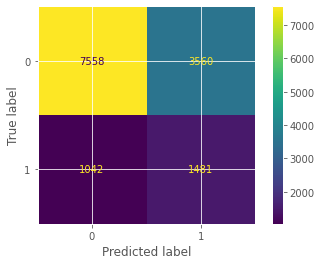

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test, pred);

Las variables más importantes para el modelo a la hora de determinar si un vuelo va a llegar al aeropuerto con retraso o no son las relacionadas a la fecha del vuelo (número de dia, dia de la semana, mes, periodo del dia), en un segundo orden las variables relacionadas al clima en que aterrizó el vuelo (visibilidad, condiciones) y en tercer orden tanto el destino como la compañía que opera el vuelo.

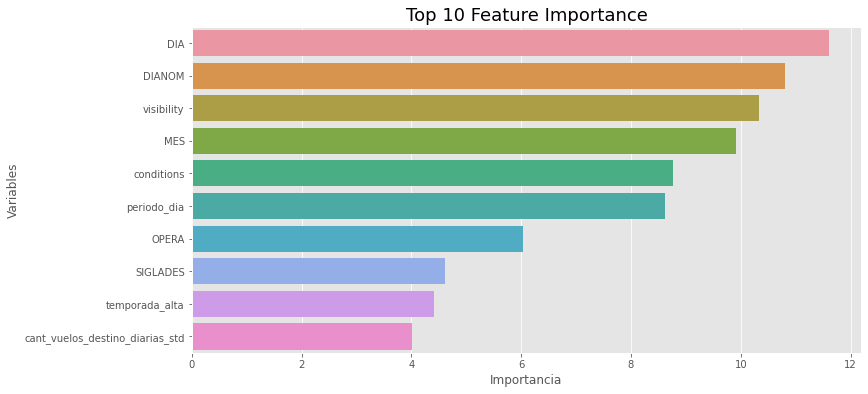

In [51]:
feature_importance = pd.Series(modelo.feature_importances_, index= modelo.feature_names_)

plt.figure(figsize= (12, 6))
sns.barplot(x= feature_importance.nlargest(10).values, y= feature_importance.nlargest(10).index)
plt.ylabel('Variables')
plt.xlabel('Importancia')
plt.title('Top 10 Feature Importance', fontsize= 18);

Como medidas para mejorar el desempeño del modelo buscaría datos de otros años para poder generalizar más sobre la situación. En nuestro caso, solo tenemos vuelos para 2017 que puede o no ser un año representativo para los vuelos, de todos modos al tener data anualizada se pueden incoporar analisis de estacionalidad.

Como último punto de mejora, buscaría datos de vuelos que llegan al Aeropuerto de Santiago para poder captar más variedad e información sobre lo que puede influir sobre la demora de un vuelo.